In [2]:
from tensorflow import keras

# <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">آموزش یک شبکه عصبی کانولوشنالی از ابتدا</div>

<div style="direction:rtl;text-align:right;font-family:Tahoma">
کدها  برگرفته از فصل دو کتاب
</div>

[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff)
<div style="direction:rtl;text-align:right;font-family:Tahoma">
و گیت هاب نویسنده کتاب و توسعه دهنده کراس 
</div>

[François Chollet](http://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb)
<div style="direction:rtl;text-align:right;font-family:Tahoma">
است.
</div>


# <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">مجموعه داده</div>

<div style="direction:rtl;text-align:right;font-family:Tahoma">
مجموعه داده گربه در مقابل سگ برای این مثال استفاده شده است. این مجموعه داده در چالش بینایی کامپیوتر اواخر سال ۲۰۱۳ توسط سایت Kaggle.com در دسترس عموم قرار گرفت.
<br>
از قبل از سال ۲۰۱۳ استفاده از شبکه های کانولوشنالی خیلی رایج نبود.
مجموعه داده در آدرس زیر قابل دانلود است.
</div>

`https://www.kaggle.com/c/dogs-vs-cats/data`



![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 
95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our 
models on less than 10% of the data that was available to the competitors.
This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). After downloading 
and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation 
set with 500 samples of each class, and finally a test set with 500 samples of each class.

Here are a few lines of code to do this:

In [3]:
import os, shutil , random, glob

In [4]:
original_dataset_dir = "./PetAllImages"
cat_src_dir = os.path.join(original_dataset_dir, "Cat")

files = glob.glob(os.path.join(cat_src_dir, "*.jpg"))
random.shuffle(files)



In [5]:
dog_src_dir = os.path.join(original_dataset_dir, "Dog")

files = glob.glob(os.path.join(dog_src_dir, "*.jpg"))
random.shuffle(files)




In [6]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = './PetAllImages'

# The directory where we will
# store our smaller dataset
base_dir = './PetAllImages/catVsdog'
os.makedirs(os.path.join(base_dir), exist_ok=True)


In [7]:
def make_dirs():
    for s in ["train","validation","test"]:
        for c in ["cats","dogs"]:
            os.makedirs(os.path.join(base_dir, s, c), exist_ok=True)

In [8]:
def split_and_copy(src_dir, dst_base, cls_name,
                   n_train=1000, n_val=500, n_test=500):
    
    files = glob.glob(os.path.join(src_dir, "*.jpg"))
    random.shuffle(files)

    train_files = files[:n_train]
    val_files   = files[n_train:n_train+n_val]
    test_files  = files[n_train+n_val:n_train+n_val+n_test]

    for f in train_files:
        shutil.copyfile(f, os.path.join(dst_base, "train", cls_name, os.path.basename(f)))

    for f in val_files:
        shutil.copyfile(f, os.path.join(dst_base, "validation", cls_name, os.path.basename(f)))

    for f in test_files:
        shutil.copyfile(f, os.path.join(dst_base, "test", cls_name, os.path.basename(f)))

In [9]:
split_and_copy(cat_src_dir, base_dir, "cats")
split_and_copy(dog_src_dir, base_dir, "dogs")

In [10]:
import tensorflow as tf

In [11]:
base_dir = "./PetAllImages/catVsDog"

train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "validation")
test_dir  = os.path.join(base_dir, "test")


In [12]:

IMG_SIZE = (150, 150)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"   # cats=0, dogs=1
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)


Found 5551 files belonging to 2 classes.
Found 1956 files belonging to 2 classes.
Found 1957 files belonging to 2 classes.


In [23]:
import tensorflow as tf

train_ds = train_ds.ignore_errors()
val_ds   = val_ds.ignore_errors()
test_ds  = test_ds.ignore_errors()
print("train cardinality:", train_ds.cardinality().numpy())
print("val cardinality:", val_ds.cardinality().numpy())
print("test cardinality:", test_ds.cardinality().numpy())



train cardinality: -2
val cardinality: -2
test cardinality: -2


In [24]:
x, y = next(iter(train_ds))
print(x.shape, y.shape)


(32, 150, 150, 3) (32, 1)


In [26]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [27]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will 
use binary crossentropy as our loss (as a reminder, check out the table in Chapter 4, section 5 for a cheatsheet on what loss function to 
use in various situations).

In [29]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [30]:
import os
from PIL import Image

base_dir = "./PetAllImages/catVsDog"
splits = ["train", "validation", "test"]
classes = ["cats", "dogs"]

bad_files = []

for split in splits:
    for cls in classes:
        folder = os.path.join(base_dir, split, cls)
        for fname in os.listdir(folder):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            path = os.path.join(folder, fname)
            try:
                with Image.open(path) as img:
                    img.convert("RGB")  # اگر نشه یعنی فایل مشکل داره
            except Exception as e:
                bad_files.append((path, str(e)))

print("Bad files found:", len(bad_files))
for p, e in bad_files[:10]:
    print("BAD:", p, "|", e)

# حذف فایل‌های خراب
for p, _ in bad_files:
    try:
        os.remove(p)
    except:
        pass

print("✅ Removed bad files.")


Bad files found: 0
✅ Removed bad files.


In [31]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

Epoch 1/30
    172/Unknown 114s 651ms/step - acc: 0.5335 - loss: 6.0376

C:\Users\Public\ANACONDA\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


172/172 ━━━━━━━━━━━━━━━━━━━━ 126s 718ms/step - acc: 0.5480 - loss: 2.0547 - val_acc: 0.5838 - val_loss: 0.6825
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 146s 849ms/step - acc: 0.6328 - loss: 0.6634 - val_acc: 0.6391 - val_loss: 0.6597
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 134s 777ms/step - acc: 0.7037 - loss: 0.5702 - val_acc: 0.6288 - val_loss: 0.7182
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 144s 837ms/step - acc: 0.7518 - loss: 0.5051 - val_acc: 0.6385 - val_loss: 0.7868
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 100s 582ms/step - acc: 0.7948 - loss: 0.4246 - val_acc: 0.6943 - val_loss: 0.6506
Epoch 6/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 100s 583ms/step - acc: 0.8373 - loss: 0.3526 - val_acc: 0.7393 - val_loss: 0.6362
Epoch 7/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 105s 610ms/step - acc: 0.8737 - loss: 0.2884 - val_acc: 0.7244 - val_loss: 0.6755
Epoch 8/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 105s 608ms/step - acc: 0.8996 - loss: 0.2331 - val_acc: 0.7336 - val_loss: 0.6738
Epoch 9/30
172/172 ━━━━━━━━━━━━━━━━

In [32]:
test_loss, test_acc = model.evaluate(test_ds)
print("✅ test acc:", test_acc)


61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - acc: 0.7766 - loss: 1.4326
✅ test acc: 0.7766233682632446


In [35]:
images, labels = next(iter(train_ds))
print(images.shape)   # (BATCH_SIZE, 150, 150, 3) 
print(labels.shape)   #  (BATCH_SIZE,) یا (BATCH_SIZE, 1) 
print(labels[:10])


(32, 150, 150, 3)
(32, 1)
tf.Tensor(
[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]], shape=(10, 1), dtype=float32)


Text(0.5, 1.0, 'label = dog 🐶')

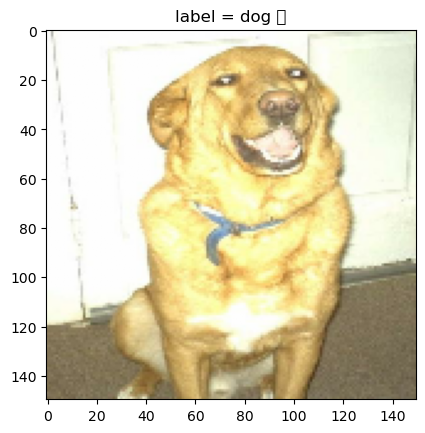

In [41]:
import matplotlib.pyplot as plt
i=1
plt.imshow(images[i] / 255.0)
plt.title("label = " + ("dog 🐶" if labels[i][0] == 1 else "cat 🐱"))

Let's plot the loss and accuracy of the model over the training and validation data during training:

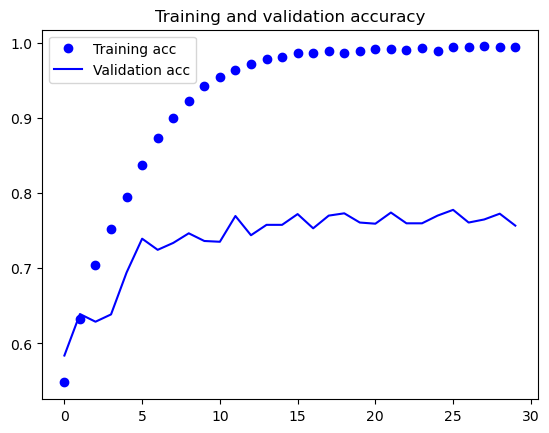

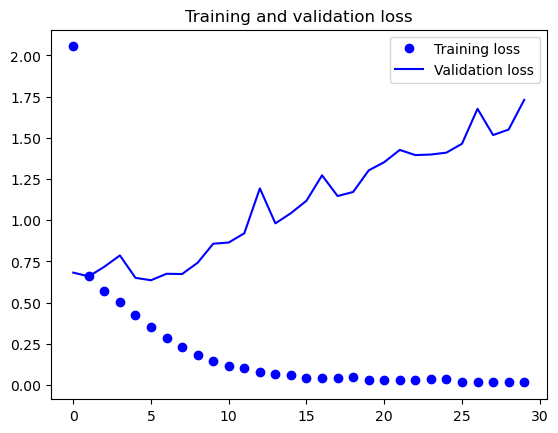

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss 
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern.
Let's train our network using data augmentation and dropout:

## <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">شبکه با Dropout</div>

In [44]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history = model.fit(
      train_ds,
    validation_data=val_ds,
    epochs=100)

Epoch 1/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 89s 505ms/step - acc: 0.5586 - loss: 1.5421 - val_acc: 0.6125 - val_loss: 0.6565
Epoch 2/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 99s 576ms/step - acc: 0.6001 - loss: 0.6838 - val_acc: 0.6293 - val_loss: 0.6336
Epoch 3/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 105s 613ms/step - acc: 0.6466 - loss: 0.6387 - val_acc: 0.6697 - val_loss: 0.6082
Epoch 4/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 90s 525ms/step - acc: 0.6812 - loss: 0.5997 - val_acc: 0.6933 - val_loss: 0.5919
Epoch 5/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 95s 551ms/step - acc: 0.7062 - loss: 0.5667 - val_acc: 0.6789 - val_loss: 0.6031
Epoch 6/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 88s 513ms/step - acc: 0.7348 - loss: 0.5324 - val_acc: 0.7321 - val_loss: 0.5270
Epoch 7/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 80s 466ms/step - acc: 0.7527 - loss: 0.5079 - val_acc: 0.7331 - val_loss: 0.5306
Epoch 8/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 99s 577ms/step - acc: 0.7767 - loss: 0.4732 - val_acc: 0.7377 - val_loss: 0.5322
Epoch 9/100
172/172 ━━━

Epoch 61/100
100/100 [==============================] - 12s 124ms/step - loss: 0.0446 - acc: 0.9855 - val_loss: 0.9633 - val_acc: 0.7660
Epoch 62/100
100/100 [==============================] - 12s 124ms/step - loss: 0.0351 - acc: 0.9905 - val_loss: 1.0186 - val_acc: 0.7610
Epoch 63/100
100/100 [==============================] - 12s 124ms/step - loss: 0.0574 - acc: 0.9775 - val_loss: 0.9036 - val_acc: 0.7680
Epoch 64/100
100/100 [==============================] - 12s 123ms/step - loss: 0.0357 - acc: 0.9875 - val_loss: 1.0182 - val_acc: 0.7650
Epoch 65/100
100/100 [==============================] - 12s 124ms/step - loss: 0.0403 - acc: 0.9865 - val_loss: 1.1160 - val_acc: 0.7610
Epoch 66/100
100/100 [==============================] - 12s 123ms/step - loss: 0.0414 - acc: 0.9865 - val_loss: 1.0252 - val_acc: 0.7580
Epoch 67/100
100/100 [==============================] - 12s 124ms/step - loss: 0.0317 - acc: 0.9890 - val_loss: 1.0357 - val_acc: 0.7750
Epoch 68/100
100/100 [===================

Let's plot our results again:

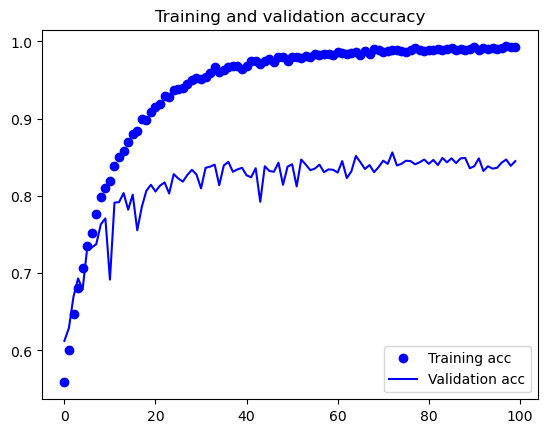

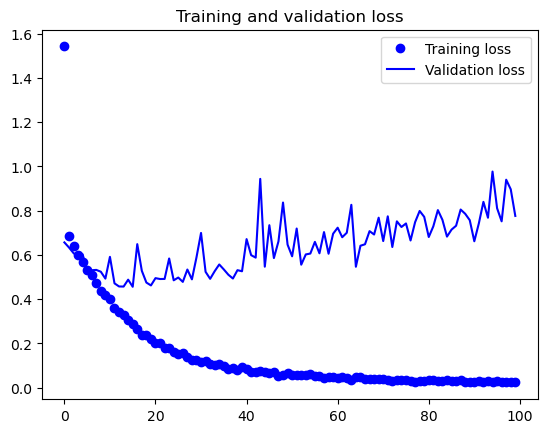

In [45]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">ذخیره کردن مدل</div>


In [ ]:
model.save('cats_and_dogs_small_1.keras')

<div class="alert alert-block alert-info">
<div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma"> دوره یادگیری عمیق<br>علیرضا اخوان پور
</div>
<a href="http://class.vision">Class.Vision</a> - <a href="http://AkhavanPour.ir">AkhavanPour.ir</a> - <a href="https://github.com/Alireza-Akhavan/">GitHub</a>

</div>